In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
print(tf.__version__)

2.2.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Series")
    plt.grid("True")

In [3]:
def trend(time, slope=0):
    return slope*time

In [4]:
def seasonal_pattern(season_time):
    return np.where(season_time<0.4,
                    np.cos(season_time*2*np.pi),
                    1/np.exp(3*season_time))

In [5]:
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

In [6]:
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [7]:
time = np.arange(4*365 +1, dtype='float32')
baseline=10
series=trend(time, 0.1)
baseline =10
amplitude = 40
slope = 0.05
noise_level=0.5

In [8]:
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [10]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.float32, tf.float32)>


In [11]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse",optimizer = tf.keras.optimizers.SGD(lr=1e-10, momentum=0.9))
model.fit(dataset, epochs=100)

print(f"Layer weights {l0.get_weights()}")

Epoch 1/100
31/31 [==============================] - 0s 14ms/step - loss: 13878.8584
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 13813.6738
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 13742.1553
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 13671.0244
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 13600.1523
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 13530.3027
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 13459.9395
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 13390.1123
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 13320.9443
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 13252.1904
Epoch 11/100
31/31 [==============================] - 0s 5ms/step - loss: 13183.3613
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss:

In [12]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)
model.compile(loss="mse",optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 4ms/step - loss: 1557.2427
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 84.5693
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 60.3132
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 54.5237
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 52.0354
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 49.4233
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 47.4705
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 45.9581
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 44.1301
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 42.6667
Epoch 11/100
31/31 [==============================] - 0s 4ms/step - loss: 41.0404
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 39.6508
Epoch 13/100
31/31 [===

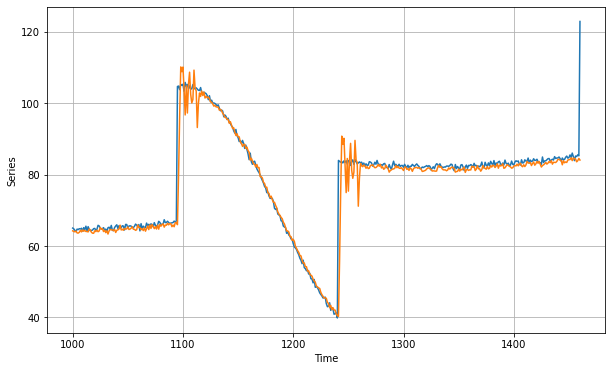

In [13]:
forecast = []
for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]
plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)


In [28]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=329.73627>>